# Realestate Optimization using QAOA

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from datetime import datetime
import numpy as np
from itertools import permutations

from qiskit_finance.data_providers import YahooDataProvider
import json # Necessary for YahooDataProvider
import http.client # Necessary for YahooDataProvider

import pandas as pd
import pandas_datareader as web

import os

from docplex.mp.model import Model

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.converters import LinearEqualityToPenalty

from qiskit.circuit.library import TwoLocal # For Ansatz

from qiskit.algorithms.optimizers import COBYLA, ADAM, NELDER_MEAD, POWELL, SPSA, QNSPSA
from qiskit.opflow import CVaRExpectation
from qiskit.opflow import PauliExpectation

from qiskit.algorithms import VQE
from qiskit.algorithms import QAOA

from qiskit import Aer
import plotly.express as px

## Load Data

5개년 KB realestate에서 가져온 부분의 

In [2]:
df = pd.read_csv("../data/index/seoul_5year_250steps_25gu.csv", encoding="UTF-8", header= "infer")
date = pd.date_range("2017-9-11", "2022-9-5", periods= 250)
df.index = date.normalize()
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
2017-09-11,73.431,63.768,75.319,70.493,65.815,65.705,65.650,66.073,67.745,64.093,...,61.130,66.277,60.562,62.045,66.802,68.752,65.605,62.143,67.035,65.095
2017-09-18,73.444,63.819,75.437,70.547,65.831,65.777,65.774,66.150,67.864,64.144,...,61.197,66.376,60.606,62.122,66.834,68.777,65.659,62.209,67.130,65.126
2017-09-25,73.463,63.891,75.604,70.666,65.898,65.872,65.890,66.183,68.000,64.211,...,61.265,66.429,60.699,62.187,66.946,68.809,65.733,62.306,67.234,65.166
2017-10-02,73.480,63.958,75.604,70.813,65.921,66.026,66.058,66.213,68.040,64.304,...,61.327,66.582,60.819,62.226,66.963,68.905,65.832,62.436,67.342,65.198
2017-10-10,73.505,64.053,75.696,70.975,66.067,66.188,66.192,66.314,68.105,64.367,...,61.375,66.708,60.963,62.337,67.014,68.999,65.959,62.646,67.458,65.245


In [3]:
df_gu = df.drop('전국',axis= 1)
df_gu = df.drop('수도권',axis= 1)
df_gu = df.drop('서울',axis= 1)

In [4]:
# Normalize gu data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = list(df.index), y = df[i], name = i)
  fig.show()

# calulate the daily return instead of 'pct_change'
def daily_return(df):
  df_daily_return = df.copy()
  for i in df.columns[1:]:
    for j in range(1, len(df)):
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    df_daily_return[i][0] = 0
  return df_daily_return

In [5]:
df_gu = normalize(df_gu)

In [6]:
interactive_plot(df_gu, 'Time plot based index Price')

In [45]:
numAssets = 10

#### Calculate the mean - Pereiod Return's $\Sigma$

In [37]:
df_gu_scaled = df_gu.drop(columns=['전국',  '중랑구', '성북구',
       '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구','종로구','중구', '수도권'])

In [38]:
df_return = df_gu_scaled.pct_change(periods= 2)
df_return.tail()

,용산구,성동구,광진구,동대문구,동작구,관악구,서초구,강남구,송파구,강동구
2022-08-06,0.000214,-0.000119,-0.000157,0.000000,-0.000387,0.000010,0.000069,-0.000393,-0.000658,-0.000130
2022-08-14,0.000205,-0.000119,-0.000157,-0.000461,-0.000645,-0.000130,0.000059,-0.000708,-0.001236,-0.000210
2022-08-21,0.000205,0.000000,-0.000187,-0.000611,-0.000794,-0.000140,-0.000147,-0.000393,-0.001635,-0.000869
2022-08-28,0.000019,-0.000109,-0.002205,-0.000180,-0.000914,-0.000728,-0.000294,-0.000394,-0.002464,-0.002069
2022-09-05,-0.000127,-0.000457,-0.002245,-0.001923,-0.000616,-0.000728,-0.000382,-0.000649,-0.003135,-0.001510


In [39]:
mu = df_return.mean().to_numpy()
sigma = df_return.cov().to_numpy()

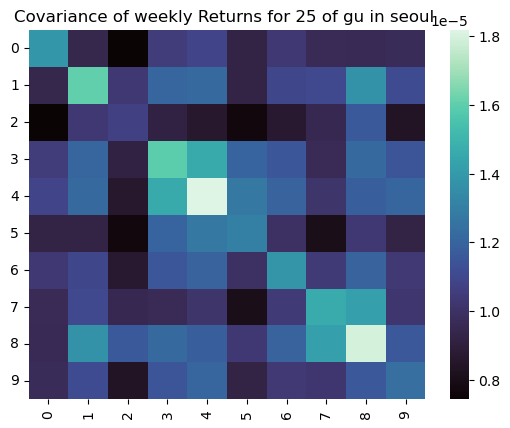

In [40]:
# 한국어 입력값으로 인해 tick 값이 error가 생겨서 일단은 ticklabel 제외함 
covHeatmap = sn.heatmap(sigma,cmap="mako")
# covHeatmap.set(xticklabels=realestates,yticklabels=realestates)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.title("Covariance of weekly Returns for 25 of gu in seoul " )
plt.show()

#### 연산시간이 너무 걸려서 일단 상위 8개 지역으로 code check으로 돌려봄

## QUBO model as Modeling Ising DOcpplex

[참고할 doc](http://ibmdecisionoptimization.github.io/docplex-doc/).  
 DOcplex to construct the quadratic program the specifications in the introduction, as it is compatible with pandas, numpy, and qiskit.

In [61]:
q = 0.5
B = 5

In [62]:
mdl = Model("Non-Scaled") # You can input a string into the argument if you want to name the model.

x = mdl.binary_var_list('x{}'.format(i) for i in range(numAssets)) # binary decision variables

# Objective Function to be maximized
objective = mdl.sum([mu[i]*x[i] for i in range(numAssets)])
objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(numAssets) for j in range(numAssets)])

mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(numAssets)) == B) # Adding the budget constraint

qp = from_docplex_mp(mdl) # Conversion to a quadratic program

In [63]:
qp

<QuadraticProgram: maximize -6.938273816735559e-06*x0^2 - 9.437517786636849e-0..., 10 variables, 1 constraints, 'Non-Scaled'>

In [64]:
classicalResult = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
# classicalResultEigenstate = (classicalResult.min_eigen_solver_result.eigenstate._primitive.data.real).tolist()
classicalResultEigenstate = classicalResult.min_eigen_solver_result.eigenstate.to_dict_fn().primitive
classicalResult

<MinimumEigenOptimizationResult: fval=0.018246360993935586, x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=1.0, x9=0.0, status=SUCCESS>

In [49]:
# making the labels for plotting
# labels = []
# for i in range(2**numAssets):
#     labels.append(format(i,'0'+str(numAssets)+'b'))
# fig = plot_histogram(dict(zip(labels, classicalResultEigenstate)),figsize=(60,10))
fig = plot_histogram(classicalResultEigenstate,figsize=(60,10))
fig.savefig("../figures/ClassicalEigensolver.pdf")
# fig

/opt/homebrew/Caskroom/miniforge/base/envs/DL-torch/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:303: ComplexWarning:

Casting complex values to real discards the imaginary part



classical eigensolver's Results 

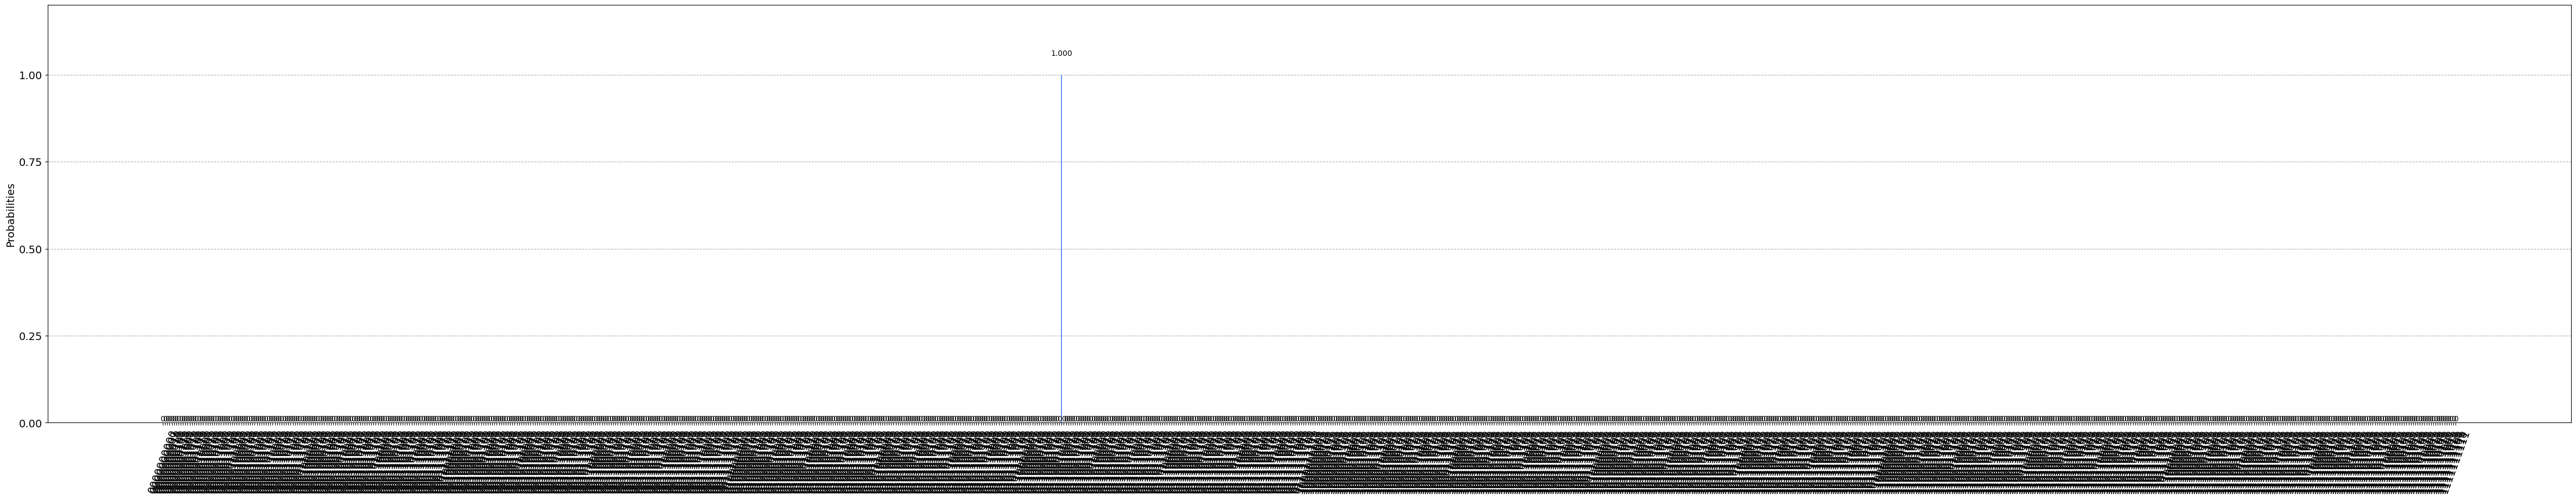

In [65]:
fig

### Converting Quadratic Program into QUBO

In [66]:
penalty = 10

In [67]:
linearToPenalty = LinearEqualityToPenalty(penalty=penalty)
qubo = linearToPenalty.convert(qp)

### QAOA_ qiskit implementation

In [68]:
def getCountDictStateVecSim(vqeResult):
    tempState = []
    tempProb = []
    for sample in vqeResult.samples:
        tempProb.append(sample.probability)
        tempStr = ''
        for stateElement in reversed(sample.x):
            tempStr += str(int(stateElement))
        tempState.append(tempStr)
    return dict(zip(tempState, tempProb))

In [69]:
maxIter = 10000
# fidelity = QNSPSA.get_fidelity(ansatz) # only for QNSPSA
optimizer = SPSA(maxiter=500)  

# Classical optimizer – COBYLA(maxiter=maxIter), ADAM(maxiter=maxIter), NELDER_MEAD(maxiter=maxIter), 
# POWELL(maxiter=maxIter), SPSA(maxiter=100), QNSPSA(fidelity,maxiter=100)

reps = 2

backend = Aer.get_backend('statevector_simulator') # statevector_simulator, qasm_simulator, aer_simulator_statevector

[16 비트이상 사용시 error ](https://qiskit.org/documentation/stubs/qiskit.opflow.state_fns.OperatorStateFn.to_matrix.html)

In [70]:
qaoaInit = QAOA(optimizer=optimizer, reps=reps, quantum_instance=backend)
qaoa = MinimumEigenOptimizer(qaoaInit)
qaoaResult = qaoa.solve(qubo)
if backend.name() == 'qasm_simulator':
    counts = qaoaResult.min_eigen_solver_result.eigenstate
elif backend.name() == 'statevector_simulator':
    counts = getCountDictStateVecSim(qaoaResult)
#endif

/opt/homebrew/Caskroom/miniforge/base/envs/DL-torch/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning:

divide by zero encountered in det

/opt/homebrew/Caskroom/miniforge/base/envs/DL-torch/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning:

invalid value encountered in det



In [71]:
qaoaResult

<MinimumEigenOptimizationResult: fval=0.018246360993941835, x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=1.0, x9=0.0, status=SUCCESS>

In [72]:
qaoaFig = plot_histogram(counts,figsize=(400,10))
qaoaFig.savefig("../figures/QAOA.pdf")

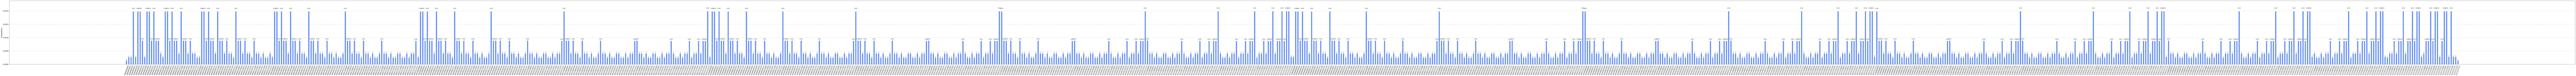

In [73]:
qaoaFig

### 결과 부분 비교

In [59]:
classicalResult

<MinimumEigenOptimizationResult: fval=0.01478401775747463, x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=1.0, x9=0.0, status=SUCCESS>

In [60]:
qaoaResult

<MinimumEigenOptimizationResult: fval=0.01478401775744942, x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=1.0, x9=0.0, status=SUCCESS>

## Data Visualization 

In [74]:
def getCombinations(inputVal):
    combinations = []
    if type(inputVal) == str:
        for perm in set(permutations(inputVal)):
            combinations.append(''.join(perm))
        #endFor
    elif type(inputVal) == list:
        for i in range(len(inputVal)):
            inputVal[i] = int(inputVal[i])
        #endFor
        for perm in set(permutations(inputVal)):
            combinations.append(list(perm))
        #endFor
    else:
        print("Input a string or list of ones and zeroes")
    return combinations

def countNonZeroElemInList(inputList):
    numNonZeroElem = 0.
    for x in inputList:
        if x != 0:
            numNonZeroElem += 1
        else:
            numNonZeroElem += 0
        #endIf
    #endFor
    return numNonZeroElem

def assetTotalPortfolioGrowth(initialPortfolioValue,selectedAssets,testDF):
    amountSplit = initialPortfolioValue/countNonZeroElemInList(selectedAssets)
    assetGrowth = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempDF = testDF.iloc[:,i]
            amountTemp = amountSplit
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
            assetGrowth.append(amountTemp)
        else:
            assetGrowth.append(0.)
        #endIf
    #endFor
    return assetGrowth

def assetGrowthTimeSeries(initialPortfolioValue,selectedAssets,testDF):
    amountSplit = initialPortfolioValue/countNonZeroElemInList(selectedAssets)
    assetGrowthTS = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            amountTemp = amountSplit
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
                tempVec.append(amountTemp)
            assetGrowthTS.append(tempVec)
        else:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            for pctChg in tempDF:
                tempVec.append(0.0)
            assetGrowthTS.append(tempVec)
        #endIf
    #endFor
    return assetGrowthTS

def assetGrowthTimeSeriesWeighted(initialPortfolioValue,selectedAssets,testDF,weights):
    assetGrowthTS = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            amountTemp = initialPortfolioValue*weights[i]
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
                tempVec.append(amountTemp)
            assetGrowthTS.append(tempVec)
        else:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            for pctChg in tempDF:
                tempVec.append(0.0)
            assetGrowthTS.append(tempVec)
        #endIf
    #endFor
    return assetGrowthTS


def portfolioGrowthTimeSeries(portfolioTS):
    portfolioValueTS = []
    for i in range(len(portfolioTS[0])):
        tempVal = 0.0
        for j in range(len(portfolioTS)):
            tempVal += portfolioTS[j][i]
        portfolioValueTS.append(tempVal)
    return portfolioValueTS

In [83]:
assetTest = qaoaResult.x.tolist() 
amountInit = 1000

In [84]:
allAssetCombinations = getCombinations(assetTest)

In [85]:
dateList = df_gu_scaled.index

In [86]:
idx = list(df_return.index)

In [87]:
startDate = idx[0]
endDate = idx[-1]

In [89]:
10 * 9 * 8 * 7 * 6 / 120

252.0

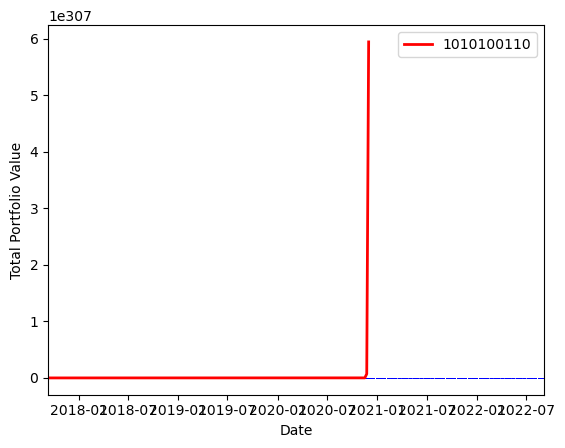

In [88]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
for i in range(len(allAssetCombinations)):
    chosenAssetsTimeSeries = assetGrowthTimeSeries(amountInit,allAssetCombinations[i],normalize(df))
    portfolioTimeSeries = portfolioGrowthTimeSeries(chosenAssetsTimeSeries)
    label = ''
    for element in allAssetCombinations[i]:
        label+=str(element)
    #endFor
    ax.plot(dateList,portfolioTimeSeries,color='blue',linestyle='--',alpha=0.1,linewidth=0.5)
#endFor

winningAssetCombination = assetTest
winningAssetTimeSeries = assetGrowthTimeSeries(amountInit,winningAssetCombination,normalize(df))
winningPortfolioTimeSeries = portfolioGrowthTimeSeries(winningAssetTimeSeries)

label = ''
for element in winningAssetCombination:
    label+=str(element)
#endFor
ax.plot(dateList,winningPortfolioTimeSeries,label=label,color='red',alpha=1,linewidth=2)

plt.xlim(startDate,endDate)
plt.ylabel('Total Portfolio Value')
plt.xlabel('Date')
plt.legend()#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# fig.savefig('figures/portfolio-'+label+'risk-'+str(q)+'-'+startStr+"-"+endStr+'.pdf',bbox_inches='tight')